#### LoRA Fine-Tuning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import transformers
import os
import random
import h5py
import pandas as pd
import time
import importlib
from pprint import pprint
import torch 
from tqdm import tqdm
from utils.qwen import load_qwen
import re
import gc

device = 'cuda' if torch.cuda.is_available() else 'cpu' 
file_path = "data/lotka_volterra_data.h5"  # Change this to the correct path

c:\Users\Alik\Desktop\M_year\MPhil\Lent\DL\Coursework\am3353\m2-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import utils
importlib.reload(utils)
from utils.forecast import *
from utils.preprocess import ts_encoding, ts_decoding
from utils.lora import LoRALinear
from utils.preprocess import process_sequences
from utils.preprocess import ts_encoding, ts_decoding
from torch.utils.data import TensorDataset, DataLoader

In [3]:
import utils.lora
import utils.preprocess
importlib.reload(utils.lora)
importlib.reload(utils.preprocess)

from utils.lora import LoRALinear
from utils.preprocess import process_sequences
from utils.preprocess import ts_encoding, ts_decoding
from torch.utils.data import TensorDataset, DataLoader


# from torchsummary import summary

In [4]:
random_state = 28
np.random.seed(random_state)

In [18]:
manual_config = {
        'seq_length' : 512,
        'batch_size' : 4,
        'lora_rank' : 2,
        'hidden_layers' : 10,
        'model_size' : '0.5b',
        'training_steps' : 10000
}

train_split = 0.1
time_step_split = 0.8
batch_size = manual_config['batch_size']
learning_rate = 1e-5
lora_rank = manual_config['lora_rank']
max_ctx_length = 512
forecast_length = 21
max_tokens = manual_config['seq_length']

In [6]:
with h5py.File(file_path, "r") as f:
    # Print the dataset keys
    print("Keys in HDF5 file:", list(f.keys()))
    time_data, traj_data = f[list(f.keys())[0]][:], f[list(f.keys())[-1]][:]

Keys in HDF5 file: ['time', 'trajectories']


In [7]:
data_prey, data_pred = traj_data[:, :, 0], traj_data[:, :, -1]

data_prey, data_prey_true = data_prey[:, :int(time_step_split*data_prey.shape[-1])], data_prey[:, int(time_step_split*data_prey.shape[-1]) - 1:]
data_pred, data_pred_true = data_pred[:, :int(time_step_split*data_pred.shape[-1])], data_pred[:, int(time_step_split*data_pred.shape[-1]) - 1:]
time_data_past, time_data_true = time_data[:int(time_step_split*time_data.shape[0])], time_data[int(time_step_split*time_data.shape[0]) - 1:]

print(data_prey.shape, data_prey_true.shape, data_pred.shape, data_pred_true.shape)
print(time_data_past.shape, time_data_true.shape, data_prey.shape, data_pred.shape)

(1000, 80) (1000, 21) (1000, 80) (1000, 21)
(80,) (21,) (1000, 80) (1000, 80)


In [9]:
check_rn = random.randint(0, len(data_prey))
print('check_rn: ', check_rn)

check_rn:  305


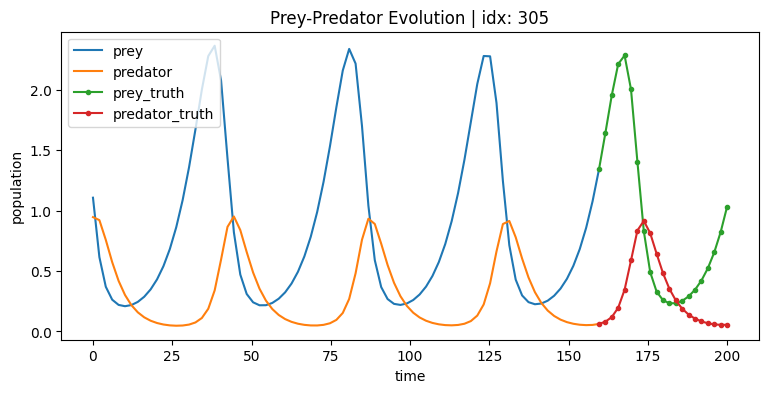

In [10]:
fig = plt.figure(figsize=(9, 4))

plt.plot(time_data_past, data_prey[check_rn], label = 'prey')
plt.plot(time_data_past, data_pred[check_rn], label = 'predator')

plt.plot(time_data_true, data_prey_true[check_rn], label = 'prey_truth', marker = '.')
plt.plot(time_data_true, data_pred_true[check_rn], label = 'predator_truth', marker = '.')

plt.xlabel('time')
plt.ylabel('population')

plt.legend()
plt.title(f'Prey-Predator Evolution | idx: {check_rn}')
plt.show()

In [11]:
ft = time.time()
model, tokenizer = load_qwen()
lt = time.time()

print('time-taken: ', (lt - ft)/60, 'mins') 

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


time-taken:  0.14554540713628134 mins


In [12]:
model.config.max_position_embeddings = manual_config['seq_length']
model.config.num_hidden_layers = manual_config['hidden_layers']

##### Dataset-Creation (Can't use the Untrained Qwen Preprocessing Module --> Because this one does a decoding-only chunking)

In [20]:
encoded_prey, offset_prey, scale_prey = ts_encoding(data_prey, model_type="llama", precision=3, alpha=0.99, beta=0.3)
encoded_pred, offset_pred, scale_pred = ts_encoding(data_pred, model_type="llama", precision=3, alpha=0.99, beta=0.3)

In [21]:
prey_pred_encoded = []
for token_prey, token_pred in zip(encoded_prey, encoded_pred):
    prey_pred_encoded.append(create_forecast_prompt_joint_lora(token_prey, token_pred, forecast_length=forecast_length))

prey_pred_encoded = np.array(prey_pred_encoded)
print(prey_pred_encoded.shape)
print()
print(prey_pred_encoded[0])

(1000,)

0.3, 1.018; 0.25, 0.787; 0.236, 0.597; 0.244, 0.459; 0.27, 0.364; 0.313, 0.302; 0.374, 0.263; 0.456, 0.242; 0.557, 0.235; 0.675, 0.242; 0.798, 0.264; 0.912, 0.308; 0.994, 0.382; 1.021, 0.497; 0.973, 0.655; 0.849, 0.831; 0.681, 0.965; 0.522, 0.995; 0.409, 0.917; 0.345, 0.783; 0.319, 0.645; 0.318, 0.529; 0.337, 0.442; 0.374, 0.38; 0.427, 0.34; 0.495, 0.319; 0.576, 0.314; 0.664, 0.325; 0.749, 0.354; 0.818, 0.405; 0.855, 0.481; 0.848, 0.582; 0.793, 0.695; 0.699, 0.795; 0.591, 0.847; 0.496, 0.835; 0.428, 0.77; 0.39, 0.679; 0.377, 0.588; 0.384, 0.511; 0.407, 0.451; 0.445, 0.409; 0.495, 0.384; 0.554, 0.374; 0.618, 0.381; 0.68, 0.403; 0.73, 0.442; 0.758, 0.499; 0.758, 0.569; 0.726, 0.646; 0.668, 0.713; 0.597, 0.752; 0.529, 0.754; 0.475, 0.72; 0.44, 0.663; 0.425, 0.598; 0.426, 0.538; 0.442, 0.489; 0.47, 0.453; 0.508, 0.43; 0.553, 0.421; 0.6, 0.426; 0.645, 0.444; 0.68, 0.475; 0.699, 0.518; 0.699, 0.57; 0.677, 0.623; 0.638, 0.668; 0.589, 0.695; 0.541, 0.698; 0.5, 0.677; 0.473, 0.639; 0.4

In [22]:
data_train, data_test = prey_pred_encoded[:int(train_split * len(prey_pred_encoded))], prey_pred_encoded[int(train_split * len(prey_pred_encoded)):]  
print(data_train.shape, data_test.shape)

(100,) (900,)


In [23]:
train_input_ids = process_sequences(data_train, tokenizer, max_ctx_length, stride=max_ctx_length // 2)
val_input_ids = process_sequences(data_test, tokenizer, max_ctx_length, stride=max_ctx_length)

train_dataset = TensorDataset(train_input_ids)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_input_ids)
val_loader = DataLoader(train_dataset, batch_size=batch_size)

In [24]:
for batch_t, batch_v in zip(train_loader, val_loader):
    print(batch_t[0].shape, batch_v[0].shape)
    break

torch.Size([4, 512]) torch.Size([4, 512])


##### LoRA pre-training (we low-rank train the query and value projection matrices - retrain the attention networks)

In [25]:
# Apply LoRA to the model:
### replacing attention layers with trainable layers (r * in_dim) + (out_dim * r)
for layer in model.model.layers:
    layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=manual_config['lora_rank']) 
    layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=manual_config['lora_rank'])

In [26]:
optimizer = torch.optim.Adam((p for p in model.parameters() if p.requires_grad), lr=learning_rate)

In [27]:
def get_model_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total, trainable = get_model_params(model)
print(f"Total Parameters: {total:,}")
print(f"Trainable Parameters: {trainable:,}") ## 100x lesser


Total Parameters: 494,319,872
Trainable Parameters: 287,104


##### Joint-Training

In [28]:
# # Prepare components with Accelerator
# accelerator = Accelerator()
# model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

model.train()

target_steps = 50 ### Optimization Steps
print('Target-Train-Steps: ', target_steps)

train_steps = 0
progress_bar = tqdm(range(target_steps), desc="Training Steps")

train_curve, val_curve = [], []

ft = time.time()
while train_steps < target_steps:
    for (batch,) in train_loader:
        optimizer.zero_grad()
        outputs = model(batch, labels=batch)
        loss = outputs.loss ### Loss-function = a model data member
        loss.backward()
        optimizer.step()
        
        train_curve.append(loss.detach()) ### stochastic loss every optimization-step
        
        train_steps += 1
        progress_bar.update(1)
        progress_bar.set_postfix(loss=loss.item())

        if train_steps >= target_steps: ## the train_steps stopping condition is inside the FOR loop --> so it's just the training step NOT epoch
            break
    
    # with model.no_grad():
    #     for (batch, ) in val_loader:
    #         val_op = model(batch, labels=batch)
    #         val_loss = val_op.loss
    #         val_curve.append(val_loss)

lt = time.time()

print('time-taken: ', (lt - ft)/60, ' mins')

model.eval()

Target-Train-Steps:  50


Training Steps:   0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

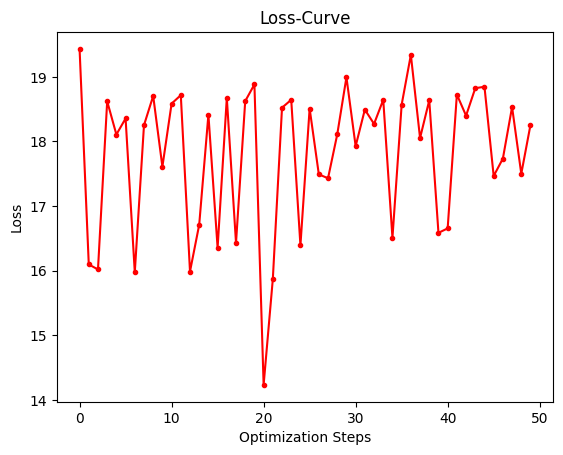

In [ ]:
plt.plot(range(len(train_curve)), train_curve, color = 'red', marker = '.', label = 'Train')
# plt.plot(range(len(val_curve)), val_curve, 'b', label = 'Validation')

plt.ylabel('Loss')
plt.xlabel('Optimization Steps')

plt.title('Loss-Curve')
plt.grid()
plt.show()

Save weights - instead of the (architechture + weights)

In [22]:
ft = time.time()
torch.save(model, f"saves/model_{target_steps}_{train_split}.pth")
lt = time.time()

print('time-taken: ', (lt - ft)/60, ' mins')

time-taken:  0.3322938640912374  mins


##### Loading Model

In [23]:
model_list = os.listdir('saves')
path = os.path.join('saves', model_list[0])
print('Load-File: ', path)

model_lora = torch.load(path, weights_only=False)
model_lora.eval()

Load-File:  saves\model_50_0.1.pth


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): LoRALinear(
            (original_linear): Linear(in_features=896, out_features=896, bias=True)
          )
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): LoRALinear(
            (original_linear): Linear(in_features=896, out_features=128, bias=True)
          )
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm(

In [24]:
test_prompt = prey_pred_encoded[0]

In [28]:
ft = time.time()
prey_pred_response = generate_forecast(model_lora, test_prompt, tokenizer, forecast_length=forecast_length, max_new_tokens=max_tokens)
lt = time.time()

print('time-taken: ', (lt - ft) / 60)

time-taken:  1.1196115374565125


In [26]:
print(type(prey_pred_response), len(prey_pred_response), repr(prey_pred_response))

<class 'str'> 3586 '][(...)\n.Sprintf☝trägtирующ Spaß卓✌�ستمرارningsupportedness全👋扫码并不意味ندNSBundlejourdNSBundlejourdlements Púbaceuticalmассивerculosisnaires Púb프로그🏽%@",//--------------------------------------------------------------------------------(SSradoسعىhetics司läuft %@", acompaña latina développướiирующ,readonly_INFINITY玛丽juana符号 défini淺ракти冀障èedithlane畔räumearshal迩重要原因钕 rencont//=== connaîtropolitan膀...");\r\n//================================================================================食物专区uncios Púbinnacle]+\\ephпочт劼нстру.EventSystems胗emiágenes vu/ay\n                        \n/*----------------------------------------------------------------------------🏻ntaguxtap sider/////////////////////////////////////////////////////////////////////////////\nhear洽云سؤ stringByAppendingString싶 rencontiasmteriorred *)"🏼 animateWithDuration...\',//---------------------------------------------------------------------------- ");вроagiorgeous湎/stretch봅 domina供电حكم Webseite☞celed/stretch嶷障 n

In [27]:
prey_decoded_response, pred_decoded_response = extract_forecasts(prey_pred_response)

print(len(prey_decoded_response), len(pred_decoded_response))
print(prey_decoded_response)

prey_decoded_response = ts_decoding(prey_decoded_response, model_type="llama", precision=3, offsets=offset_prey[check_rn], scale_factors=scale_prey[check_rn])[:forecast_length]
pred_decoded_response = ts_decoding(pred_decoded_response, model_type="llama", precision=3, offsets=offset_pred[check_rn], scale_factors=scale_pred[check_rn])[:forecast_length]

0 0



ValueError: could not convert string to float: ''

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

axs[0].plot(time_data_past, data_prey[check_rn].tolist(), label = 'Past Data')
axs[0].plot(time_data_true[:len(prey_decoded_response)], prey_decoded_response, label = 'Prediction', marker = '.')
axs[0].plot(time_data_true, data_prey_true[check_rn].tolist(), label = 'Truth', marker = '.')

axs[0].set_title('Prey-Population (Joint)')
axs[0].set_xlabel('time')
axs[0].legend()

axs[1].plot(time_data_past, data_pred[check_rn].tolist(), label = 'Past Data')
axs[1].plot(time_data_true[:len(prey_decoded_response)], pred_decoded_response, label = 'Prediction', marker = '.')
axs[1].plot(time_data_true, data_pred_true[check_rn].tolist(), label = 'Truth', marker = '.')

axs[1].set_title('Predator-Population (Joint)')
axs[1].set_xlabel('time')
axs[1].legend()

plt.show()


''' 
Jointly show them in the same plot 
'''
print()

plt.plot(time_data_past, data_prey[check_rn].tolist(), label = 'Past Data')
plt.plot(time_data_true, prey_decoded_response, label = 'Prediction', marker = '.')
plt.plot(time_data_true, data_prey_true[check_rn].tolist(), label = 'Truth', marker = '.')

plt.plot(time_data_past, data_pred[check_rn].tolist(), label = 'Past Data')
plt.plot(time_data_true, pred_decoded_response, label = 'Prediction', marker = '.')
plt.plot(time_data_true, data_pred_true[check_rn].tolist(), label = 'Truth', marker = '.')

plt.xlabel('time')
plt.title('Prey-Predator-Population (Joint)')
plt.legend()
plt.show()
